<a href="https://colab.research.google.com/github/Loki-33/LexiCo/blob/main/LexiCo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
class Token:
  def __init__(self, type_, value):
    self.type = type_
    self.value = value

  def __repr__(self):
    return f'Token({self.type}, {repr(self.value)})'

In [2]:
def is_whitespace(c):
  return c in ' \t\n'

def is_digit(c):
  return c.isdigit()

def is_letter(c):
  return c.isalpha() or c == '_'

In [37]:
def lexer(text):
  tokens = []
  i = 0

  while i < len(text):
    char = text[i]

    if is_whitespace(char):
      i += 1
      continue

    if is_letter(char):
      start = i
      while i < len(text) and (is_letter(text[i]) or text[i].isdigit()):
        i += 1
      tokens.append(Token('IDENTIFIER', text[start:i]))
      continue

    if is_digit(char):
      start = i
      while i<len(text) and text[i].isdigit():
        i += 1
      tokens.append(Token('NUMBER', text[start:i]))
      continue
    if char == '+':
      tokens.append(Token('PLUS', char))
    elif char == '-':
      tokens.append(Token('MINUS', char))
    elif char == '*':
      tokens.append(Token('MUL', char))
    elif char == '/':
      tokens.append(Token('DIV', char))
    elif char == '=':
      tokens.append(Token('ASSIGN', char))
    elif char == '(':
      tokens.append(Token('LPAREN', char))
    elif char == ')':
      tokens.append(Token('RPAREN', char))
    else:
      raise Exception(f"Unexpected character: {char}")

    i += 1

  return tokens

In [4]:
code = "x = 42 + y * (7 - 2)"
tokens = lexer(code)
for t in tokens:
  print(t)

Token(ID, 'x')
Token(ASSIGN, '=')
Token(NUMBER, '42')
Token(PLUS, '+')
Token(ID, 'y')
Token(MUL, '*')
Token(LPAREN, '(')
Token(NUMBER, '7')
Token(MINUS, '-')
Token(NUMBER, '2')
Token(RPAREN, ')')


**USING REGULAR EXPRESSION**

In [5]:
import re

In [6]:
TOKEN_SPEC = [
    ('NUMBER',      r'\d+(\.\d+)?'),    # Integer or decimal
    ('IDENTIFIER',  r'[A-Za-z_]\w*'),   # Variable/function names
    ('ASSIGN',      r'='),              # =
    ('PLUS',        r'\+'),             # +
    ('MINUS',       r'-'),              # -
    ('MUL',         r'\*'),             # *
    ('DIV',         r'/'),              # /
    ('LPAREN',      r'\('),             # (
    ('RPAREN',      r'\)'),             # )
    ('SKIP',        r'[ \t]+'),         # Spaces/tabs (ignored)
    ('NEWLINE',     r'\n'),             # Newlines (optional)
    ('MISMATCH',    r'.'),              # Any other character (error)
]

In [7]:
TOKEN_REGEX = '|'.join(f'(?P<{name}>{pattern})' for name, pattern in TOKEN_SPEC)
MASTER_RE = re.compile(TOKEN_REGEX)

In [8]:
def re_lexer(code):
  tokens = []
  for match in MASTER_RE.finditer(code):
    kind = match.lastgroup
    value = match.group()

    if kind == 'SKIP' or kind == 'NEWLINE':
      continue
    elif kind == 'MISMATCH':
      raise RuntimeError(f"Unexpected character: {value}")
    else:
      tokens.append(Token(kind, value))
  return tokens

In [9]:
code = "x = 12 + 4.5 * (y - 7)"
tokens = re_lexer(code)
for tok in tokens:
    print(tok)

Token(IDENTIFIER, 'x')
Token(ASSIGN, '=')
Token(NUMBER, '12')
Token(PLUS, '+')
Token(NUMBER, '4.5')
Token(MUL, '*')
Token(LPAREN, '(')
Token(IDENTIFIER, 'y')
Token(MINUS, '-')
Token(NUMBER, '7')
Token(RPAREN, ')')


**AST-Abstract Syntax Tree**


In [19]:
class AST:
  def __init__(self, type_, value=None, children=None):
    self.type = type_
    self.value = value
    self.childrens = children if children else []

  def __repr__(self, level=0):
    indent = "  " * level
    rep = f"{indent}{self.type}: {self.value}\n"
    for child in self.childrens:
      rep += child.__repr__(level+1)
    return rep

In [33]:
AST('IDENTITY', 'x', [AST("ASSIGN", '=', [AST("BINARY_OP", '+', [
    AST("NUMBER", 3),
    AST("NUMBER", 2)
])])])

IDENTITY: x
  ASSIGN: =
    BINARY_OP: +
      NUMBER: 3
      NUMBER: 2

**PARSER TIME**

In [46]:
class Parser:
  def __init__(self, tokens):
    self.tokens = tokens
    self.pos = 0

  def current(self):
    if self.pos < len(self.tokens):
      return self.tokens[self.pos]
    return Token('EOF', None)

  def eat(self, type_):
    if self.current().type == type_:
      self.pos += 1
    else:
      raise Exception(f"Expected token {type_}, got {self.current().type}")

  def parse(self):
    return self.parse_assignment()

  def parse_assignment(self):
    var_name = self.current().value
    self.eat('IDENTIFIER')
    self.eat('ASSIGN')
    expr = self.parse_expression()
    return AST('ASSIGN', "=", [AST("IDENTIFIER", var_name), expr])

  def parse_expression(self):
    node = self.parse_term()
    while self.current().type in ('PLUS', 'MINUS'):
      op = self.current()
      self.eat(op.type)
      right = self.parse_term()
      node = AST('BINARY_OP', op.value, [node, right])
    return node

  def parse_term(self):
    node = self.parse_factor()
    while self.current().type in ('MUL', 'DIV'):
      op = self.current()
      self.eat(op.type)
      right = self.parse_factor()
      node = AST('BINARY_OP', op.value, [node, right])
    return node

  def parse_factor(self):
    token = self.current()
    if token.type == 'NUMBER':
      self.eat('NUMBER')
      return AST('NUMBER', token.value)
    elif token.type == 'IDENTIFIER':
      self.eat('IDENTIFIER')
      return AST('IDENTIFIER', token.value)
    elif token.type == 'LPAREN':
      self.eat('LPAREN')
      node = self.parse_expression()
      self.eat('RPAREN')
      return node
    else:
      raise Exception(f"Unexpected token: {token.type}")

In [47]:
code = "x = 12 + 45 * (y - 7)"
tokens = lexer(code)
parser = Parser(tokens)
ast = parser.parse()
print(ast)

ASSIGN: =
  IDENTIFIER: x
  BINARY_OP: +
    NUMBER: 12
    BINARY_OP: *
      NUMBER: 45
      BINARY_OP: -
        IDENTIFIER: y
        NUMBER: 7



In [48]:
from graphviz import Digraph

In [55]:

dot = Digraph()
counter = [0]

def add_node(node):
  node_id = f"node{counter[0]}"
  counter[0]+= 1

  label = f'{node.type}'
  if node.value is not None:
    label += f': {node.value}'

  dot.node(node_id, label)

  for child in node.childrens:
    child_id = add_node(child)
    dot.edge(node_id, child_id)
  return node_id

add_node(ast)

'node0'

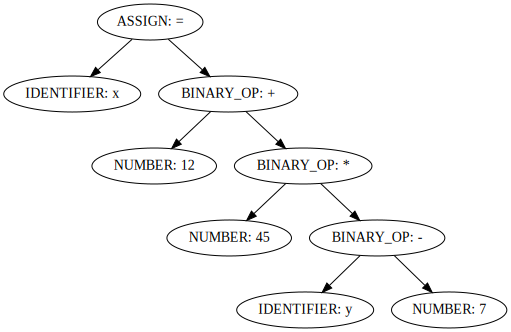

In [52]:
dot